In [ ]:
!nvidia-smi

Sun Jul 19 13:23:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
batch_size=64

In [4]:
transform = transforms.Compose([
        transforms.ToTensor()])

In [5]:
#mnist data
train_dataset = torchvision.datasets.MNIST(root='data/mnist',
                                           train=True, 
                                           transform=transform,
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='data/mnist',
                                          train=False, 
                                          transform=transform)
#put into batches
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

In [6]:
class resblock(nn.Module):
  def __init__(self,n_channels):
    super(resblock,self).__init__()
    self.process = nn.Sequential(
                                 nn.Conv2d(in_channels=n_channels,out_channels=n_channels*2,kernel_size=3,stride=1,padding=1),
                                 nn.BatchNorm2d(2*n_channels),
                                 nn.Sigmoid(),
                                 nn.Conv2d(in_channels=2*n_channels,out_channels=n_channels*4,kernel_size=3,stride=1,padding=1),
                                 nn.BatchNorm2d(4*n_channels),
                                 nn.Sigmoid(),
                                 nn.Conv2d(in_channels=4*n_channels,out_channels=n_channels*4,kernel_size=3,stride=1,padding=1),
                                 nn.BatchNorm2d(4*n_channels),
                                 nn.Sigmoid(),
                                 nn.Conv2d(in_channels=4*n_channels,out_channels=n_channels,kernel_size=3,stride=1,padding=1),
                                 nn.BatchNorm2d(n_channels),
                                 nn.Sigmoid())
  def forward(self,x):
    return x+self.process(x)


In [7]:
class vae(nn.Module):
  def __init__(self):
    super(vae,self).__init__()
    self.base_encoder = nn.Sequential(nn.Conv2d(in_channels=1,out_channels=4,kernel_size=3,stride=1,padding=1),
                                      resblock(4),
                                      nn.Conv2d(in_channels=4,out_channels=4,kernel_size=2,stride=2,padding=0),
                                      resblock(4),
                                      nn.Conv2d(in_channels=4,out_channels=1,kernel_size=3,stride=1,padding=1))
    self.y_encoder = nn.Sequential(nn.Linear(14*14,128),
                                   nn.Sigmoid(),
                                   nn.Linear(128,10))
    self.extraz = nn.Sequential(resblock(1),
                                nn.Conv2d(in_channels=1,out_channels=1,kernel_size=2,stride=2,padding=0))
    self.extray = nn.Sequential(nn.Linear(10,32),nn.Sigmoid(),nn.Linear(32,49))
    self.final = resblock(1)
    self.zmu = nn.Linear(7*7,7*7)
    self.zvar = nn.Linear(7*7,7*7)

    self.ydec = nn.Sequential(nn.Linear(10,32),nn.Sigmoid(),nn.Linear(32,49))
    self.zdec = resblock(1)
    self.commondecoder = nn.Sequential(nn.ConvTranspose2d(1,1,kernel_size=2,stride=2,padding=0),
                                       nn.Conv2d(in_channels=1,out_channels=4,kernel_size=1,stride=1,padding=0),
                                       resblock(4),
                                       nn.ConvTranspose2d(4,4,kernel_size=2,stride=2,padding=0),
                                       resblock(4),
                                       nn.Conv2d(in_channels=4,out_channels=1,kernel_size=1,stride=1,padding=0),
                                       nn.Sigmoid())
  def encode(self,x):
    x = self.base_encoder(x)
    ylogit = self.y_encoder(x.reshape(x.shape[0],14*14))
    ysoft = F.softmax(ylogit, dim=1)
    _,preds  = torch.max(ysoft, 1)
    onehot = torch.eye(10).to(device) 
    onehot = onehot[preds]
    processed_onehot = self.extray(onehot.float())
    processed_onehot = processed_onehot.reshape(processed_onehot.shape[0],1,7,7)
    final = self.final(processed_onehot+self.extraz(x))
    zmu = self.zmu(final.reshape(final.shape[0],7*7))
    zvar = self.zvar(final.reshape(final.shape[0],7*7))
    return onehot,zmu,zvar,ysoft
  def forward(self,x):
    onehot,zmu,zvar,ysoft = self.encode(x)
    processed_onehot = self.ydec(onehot.float())
    processed_onehot = processed_onehot.reshape(processed_onehot.shape[0],1,7,7)
    std = zvar.mul(0.5).exp_()
    esp = torch.randn(*zmu.size()).to(device)
    z = zmu + std * esp
    processed_z = self.zdec(z.reshape(z.shape[0],1,7,7))
    recons = self.commondecoder(processed_onehot+processed_z)
    return recons,zmu,zvar,ysoft
  def loss(self,x,y):
    recons,zmu,zvar,ysoft = self.forward(x)
    catloss = nn.CrossEntropyLoss()(ysoft,y)
    reconsloss = nn.BCELoss()(recons,x)
    klloss = -0.5 * torch.sum(1 + zvar - zmu.pow(2) - zvar.exp())/x.shape[0]
    return catloss,reconsloss,klloss
  def generate_samples(self,labels,mu,std):
    onehot = torch.eye(10).to(device) 
    onehot = onehot[labels]
    processed_onehot = self.ydec(onehot.float())
    processed_onehot = processed_onehot.reshape(processed_onehot.shape[0],1,7,7)
    z = torch.randn(labels.shape[0],7*7).to(device)
    z = z*std+mu
    processed_z = self.zdec(z.reshape(z.shape[0],1,7,7))
    recons = self.commondecoder(processed_onehot+processed_z)
    return recons




In [8]:
model = vae().to(device)

In [9]:
optim = torch.optim.Adam(model.parameters())

In [10]:
epochs=10

In [11]:
for epoch in range(epochs):
    minloss = 1
    running_kl_loss=0
    running_recons_loss=0
    running_cat_loss=0
    num_images=0
    for i,(img,label) in enumerate(train_loader):
      img = img.to(device)
      label=label.to(device)
      optim.zero_grad()
      cat_loss,recons_loss,kl_loss = model.loss(img,label)
      loss=5*recons_loss+0.1*cat_loss+(epoch/50)*kl_loss
      loss.backward()
      optim.step()
      running_cat_loss = running_cat_loss + cat_loss.item()*len(img)
      running_recons_loss = running_recons_loss + recons_loss.item()*len(img)
      running_kl_loss = running_kl_loss + kl_loss.item()*len(img)

      num_images= num_images+len(img)
    print('epoch: '+str(epoch)+' cat_loss: '+str(running_cat_loss/num_images)+' recons_loss: '+str(running_recons_loss/num_images)+' kl_loss: '+str(running_kl_loss/num_images))



epoch: 0 cat_loss: 1.669810979016622 recons_loss: 0.16880538080135982 kl_loss: 7554.758912893168
epoch: 1 cat_loss: 1.6601766915639242 recons_loss: 0.20886810086568197 kl_loss: 12.358922819519043
epoch: 2 cat_loss: 1.579672933069865 recons_loss: 0.20660865159829458 kl_loss: 2.297828810628255
epoch: 3 cat_loss: 1.5619897391637165 recons_loss: 0.2139879836320877 kl_loss: 0.83018428662618
epoch: 4 cat_loss: 1.54788779074351 recons_loss: 0.217434384171168 kl_loss: 0.3780913578828176
epoch: 5 cat_loss: 1.535346438217163 recons_loss: 0.21934034469127656 kl_loss: 0.18428993593056997
epoch: 6 cat_loss: 1.5250559982935588 recons_loss: 0.22069766844113667 kl_loss: 0.08807825516462325
epoch: 7 cat_loss: 1.5159165686289469 recons_loss: 0.22123501975536347 kl_loss: 0.04398530792792638
epoch: 8 cat_loss: 1.508063569132487 recons_loss: 0.22151994423071544 kl_loss: 0.024360647415121395
epoch: 9 cat_loss: 1.5019548556009927 recons_loss: 0.22157077426910401 kl_loss: 0.015319451528290907


In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [13]:
labels=[]
for i in range(10):
  for j in range(6):
    labels.append(i)

In [14]:
labels=torch.Tensor(np.array(labels)).long().to(device)

In [15]:
mu = torch.arange(start=-1.5, end=1.5, step=0.5)
f_mu=[]
for b in range(10):
  for a in mu:
    f_mu.append(np.array(torch.zeros(7*7)+a))
f_mu = np.array(f_mu)
f_mu = torch.Tensor(f_mu).to(device)

In [16]:
imgs = model.generate_samples(labels,torch.zeros(60,49).to(device),f_mu).cpu().detach().reshape(60,28,28)

<Figure size 432x288 with 0 Axes>

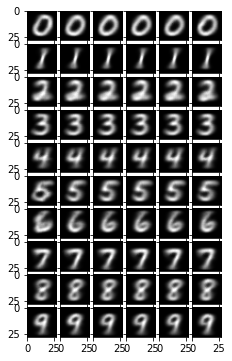

In [17]:
plt.gray()
fig = plt.figure(figsize=(10., 6.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(10, 6),  # creates 2x2 grid of axes
                 axes_pad=0.05  # pad between axes in inch.
                 )

for ax, im in zip(grid, imgs):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()